In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(font='Arial Unicode MS', font_scale=1.3)
mpl.rcParams['figure.figsize'] = [10.0, 8.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

In [2]:
from pathlib import Path

wdir = Path.cwd()

Note: this code will not run in its current state since the NetMHCpan binding predictions is ~2.0 GB and can't be hosted on GitHub.

### Data

In [4]:
## Get alleles of interest
ai_alleles =  {'HLA-B27:05', 'HLA-B57:01', 'HLA-B13:02', 'HLA-B39:06', 'HLA-B51:01', 'HLA-C12:03', 'HLA-C06:02'}
ai_B_alleles = {'HLA-B27:05', 'HLA-B57:01', 'HLA-B13:02', 'HLA-B39:06', 'HLA-B51:01'}
ai_C_alleles = {'HLA-C06:02','HLA-C12:03'}

hla_b_af = pd.read_csv(wdir.parent / 'Data' / 'HLA_Population_Frequencies' / 'HLA_B.tsv', sep='\t', header=0, names=['allele', 'af'])
hla_c_af = pd.read_csv(wdir.parent / 'Data' / 'HLA_Population_Frequencies' / 'HLA_C.tsv', sep='\t', header=0, names=['allele', 'af'])

def get_pop_alleles(freqs):
    if isinstance(freqs, pd.DataFrame):
        freqs = [freqs]
    alleles = set()
    for df in freqs:
        alleles.update(df[df.af >= 0.01].allele.tolist())
    return {'HLA-'+al.replace('*', '') for al in alleles}

pop_alleles = get_pop_alleles([hla_b_af, hla_c_af]) - ai_alleles
pop_B_alleles = get_pop_alleles(hla_b_af) - ai_alleles
pop_C_alleles = get_pop_alleles(hla_c_af) - ai_alleles

ai_alleles = sorted(list(ai_alleles))
ai_B_alleles = sorted(list(ai_B_alleles))
ai_C_alleles = sorted(list(ai_C_alleles))
pop_alleles = sorted(list(pop_alleles))
pop_B_alleles = sorted(list(pop_B_alleles))
pop_C_alleles = sorted(list(pop_C_alleles))

allele_colors = {'HLA-B51:01': 'brown', 'HLA-B57:01': 'orange', 'HLA-B27:05': 'red', 'HLA-B39:06': 'green', 'HLA-B13:02': 'blue',
                 'HLA-C06:02': 'purple', 'HLA-C12:03': 'cyan'}
allele_colors = dict(sorted(allele_colors.items()))

## Get binding predictions
bp = pd.read_feather(wdir.parent / 'Data' / 'taa_netmhcpan_el_ranks.fth')

chr_y = pd.read_csv(wdir.parent / 'Data' / 'chrY_genes.txt', sep='\t')
histones_df = pd.read_csv(wdir.parent / 'Data' / 'histones_hgnc.csv')
pseudos_df = pd.read_csv(wdir.parent / 'Data' / 'pseudogenes_hgnc.tsv', sep='\t')

histones = set(histones_df['Approved symbol'].tolist())
for s in histones_df['Previous symbols'].tolist():
    if s is np.nan:
        continue
    histones |= set(s.split(','))

pseudos = set(pseudos_df['Approved symbol'].tolist())
for s in pseudos_df['Previous symbol'].tolist():
    if s is np.nan:
        continue
    pseudos |= set(s.split(','))

gene_filter = (
    ~bp.hgnc.isin(chr_y)
    & ~bp.hgnc.isin(histones)
    & ~bp.hgnc.isin(pseudos)
)
bp = bp[gene_filter]

bp_idxd = bp.set_index(['Pos', 'Peptide', 'uniprot', 'hgnc'])

de_atgns = ['TYR', 'GPNMB', 'MAGEA10', 'MAGEE1', 'TYRP1', 'MITF', 'MTMR2', 'TIAF1', 'MTMR4', 'DCT', 'MLANA']

In [6]:
pop_B_binned = None
for al in pop_B_alleles:
    df = pd.DataFrame(pd.cut(bp[al].sort_values(ignore_index=True), np.geomspace(5e-4, 100, 1000), include_lowest=True)).rename(columns={al: 'bins'})
    ecdf = df.groupby('bins').size().values.cumsum()/df.groupby('bins').size().values.sum()
    if pop_B_binned is None:
        pop_B_binned = pd.DataFrame(ecdf, columns=[al], index=df.bins.cat.categories)
    else:
        pop_B_binned[al] = ecdf

pop_C_binned = None
for al in pop_C_alleles:
    df = pd.DataFrame(pd.cut(bp[al].sort_values(ignore_index=True), np.geomspace(5e-4, 100, 1000), include_lowest=True)).rename(columns={al: 'bins'})
    ecdf = df.groupby('bins').size().values.cumsum()/df.groupby('bins').size().values.sum()
    if pop_C_binned is None:
        pop_C_binned = pd.DataFrame(ecdf, columns=[al], index=df.bins.cat.categories)
    else:
        pop_C_binned[al] = ecdf

### Fig. 4B-D

In [ ]:
threshold = 2
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(pop_B_binned.index.mid, pop_B_binned.max(1), marker='.', ls='', color='black', label="B-allele Population Max")
plt.plot(pop_B_binned.index.mid, pop_B_binned.min(1), marker='.', ls='', color='grey', label="B-allele Population Min")
plt.fill_between(pop_B_binned.index.mid, pop_B_binned.max(1), pop_B_binned.min(1), color='C0', alpha=0.35)
for allele in ai_B_alleles:
    color = allele_colors[allele]
    sns.ecdfplot(bp.loc[:, allele], color=color, label=allele, marker='.', ls='', markersize=3)
plt.xlim([0, threshold])
plt.ylim([0, 0.035])
plt.xlabel('Percentile Rank')
plt.ylabel('Fraction of CA peptides bound')
handles = [
    mpl.lines.Line2D([], [], marker='.', ls='', color='black', label="B-allele Population Max", ms=20),
    mpl.lines.Line2D([], [], marker='.', ls='', color='grey', label="B-allele Population Min", ms=20),
]
handles.extend([mpl.lines.Line2D([], [], color=allele_colors[allele], label=allele, marker='.', ls='', ms=20) for allele in sorted(ai_B_alleles)])
plt.legend(handles=handles);

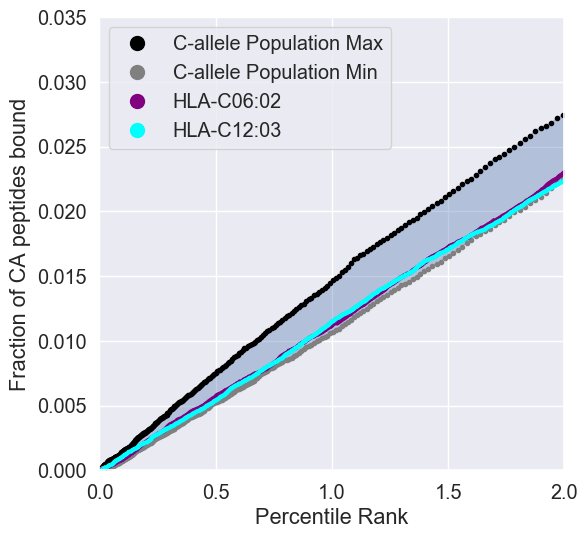

In [35]:
threshold = 2
C_colors = ['cyan', 'purple']
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(pop_C_binned.index.mid, pop_C_binned.max(1), marker='.', ls='', color='black', label="C-allele Population Max")
plt.plot(pop_C_binned.index.mid, pop_C_binned.min(1), marker='.', ls='', color='grey', label="C-allele Population Min")
plt.fill_between(pop_C_binned.index.mid, pop_C_binned.max(1), pop_C_binned.min(1), color='C0', alpha=0.35)
for allele in ai_C_alleles:
    color = allele_colors[allele]
    sns.ecdfplot(bp.loc[:, allele], color=color, label=allele, marker='.', ls='', markersize=3)
plt.xlim([0, threshold])
plt.ylim([0, 0.035])
plt.xlabel('Percentile Rank')
plt.ylabel('Fraction of CA peptides bound')
handles = [
    mpl.lines.Line2D([], [], marker='.', ls='', color='black', label="C-allele Population Max", ms=20),
    mpl.lines.Line2D([], [], marker='.', ls='', color='grey', label="C-allele Population Min", ms=20),
]
handles.extend([mpl.lines.Line2D([], [], color=allele_colors[allele], label=allele, marker='.', ls='', ms=20) for allele in sorted(ai_C_alleles)])
plt.legend(handles=handles, loc='upper left');

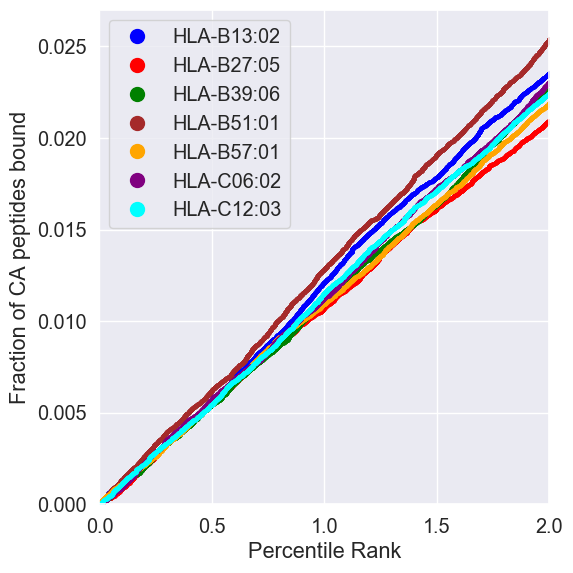

In [36]:
threshold = 2
fig, ax = plt.subplots(figsize=(6,6))
for allele in ai_alleles:
    sns.ecdfplot(bp.loc[:, allele], color=allele_colors[allele], label=allele, marker='.', ls='', ms=4)
plt.xlim([0, threshold])
plt.ylim([0, 0.027])
plt.xlabel('Percentile Rank')
plt.ylabel('Fraction of CA peptides bound')
handles = [mpl.lines.Line2D([], [], color=allele_colors[allele], label=allele, marker='.', ls='', ms=20) for allele in sorted(ai_alleles)]
plt.legend(handles=handles)
plt.tight_layout();

### Fig. S13B

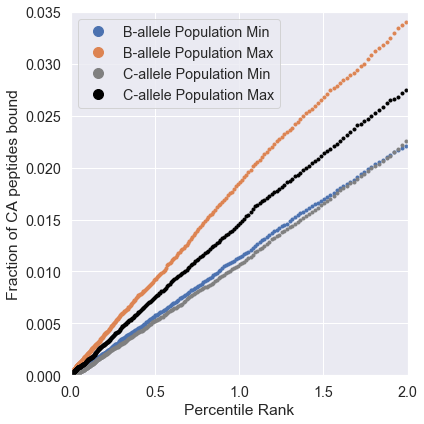

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(pop_B_binned.index.mid, pop_B_binned.min(1), marker='.', ls='', label="B-allele Population Min")
plt.plot(pop_B_binned.index.mid, pop_B_binned.max(1), marker='.', ls='', label="B-allele Population Max")
plt.plot(pop_C_binned.index.mid, pop_C_binned.min(1), marker='.', ls='', color='grey', label="C-allele Population Min")
plt.plot(pop_C_binned.index.mid, pop_C_binned.max(1), marker='.', ls='', color='black', label="C-allele Population Max")
plt.xlim([0, 2])
plt.ylim([0, 0.035])
plt.xlabel('Percentile Rank')
plt.ylabel('Fraction of CA peptides bound')
handles = []
handles.append(mpl.lines.Line2D([], [], color='C0', label="B-allele Population Min", marker='.', ls='', ms=20))
handles.append(mpl.lines.Line2D([], [], color='C1', label="B-allele Population Max", marker='.', ls='', ms=20))
handles.append(mpl.lines.Line2D([], [], color='grey', label="C-allele Population Min", marker='.', ls='', ms=20))
handles.append(mpl.lines.Line2D([], [], color='black', label="C-allele Population Max", marker='.', ls='', ms=20))
plt.legend(handles=handles)
plt.tight_layout();

### Fig. S16

/tmp/ipykernel_4012992/4184847102.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pct_cvr_long = pct_cvr_long.append(pop_pct_cvr.reset_index().melt(id_vars='hgnc', var_name='allele', value_name='pct_coverage').assign(al_set='Common'), ignore_index=True)


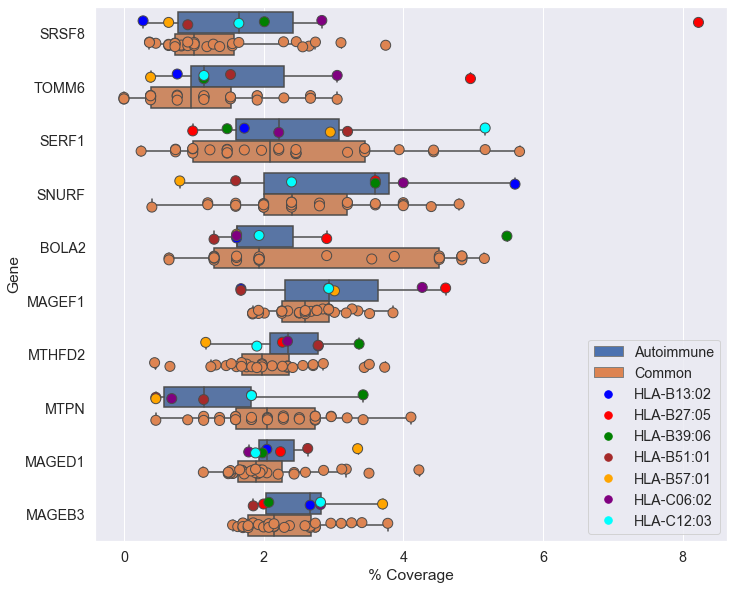

In [9]:
thresh = 2
ai_bp = bp_idxd.loc[:, bp_idxd.columns.isin(ai_alleles)]
pop_bp = bp_idxd.loc[:, bp_idxd.columns.isin(pop_alleles)]

# Percent coverage = no. of uniq peptides below threshold/(gene length * no. of tested alleles) * 100%
ai_pct_cvr = (ai_bp <= thresh).groupby('hgnc').sum().div(bp_idxd.groupby('hgnc').size(), 0) * 100
ai_pct_cvr.sort_index(inplace=True)

pop_pct_cvr = (pop_bp <= thresh).groupby('hgnc').sum().div(bp_idxd.groupby('hgnc').size(), 0) * 100
pop_pct_cvr.sort_index(inplace=True)

pct_cvr_long = ai_pct_cvr.reset_index().melt(id_vars='hgnc', var_name='allele', value_name='pct_coverage').assign(al_set='Autoimmune')
pct_cvr_long = pct_cvr_long.append(pop_pct_cvr.reset_index().melt(id_vars='hgnc', var_name='allele', value_name='pct_coverage').assign(al_set='Common'), ignore_index=True)
pct_cvr_long = pct_cvr_long.rename(columns={'hgnc': 'Gene', 'pct_coverage': '% Coverage', 'al_set': 'Allele Set'})

pct_cvr_diff = (ai_pct_cvr.max(1) - pop_pct_cvr.mean(1))/pop_pct_cvr.mean(1)*100
pct_cvr_diff = pct_cvr_diff.reindex(pct_cvr_diff.abs().sort_values(ascending=False).index)
top_n_pct_diff = pct_cvr_diff.nlargest(10).index

fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(data=pct_cvr_long[pct_cvr_long.Gene.isin(top_n_pct_diff)], y='Gene', x='% Coverage', hue='Allele Set',
            order=top_n_pct_diff, ax=ax)
sns.stripplot(data=pct_cvr_long[pct_cvr_long.Gene.isin(top_n_pct_diff)], y='Gene', x='% Coverage', hue='Allele Set',
              order=top_n_pct_diff, dodge=True, linewidth=1, size=10, ax=ax)

al_order = ['HLA-B13:02','HLA-B27:05','HLA-B39:06','HLA-B51:01','HLA-B57:01','HLA-C06:02','HLA-C12:03']
for ai_pts_row in ax.collections[0:-2:2]:
    ai_pts_row.set_fc([allele_colors[al] for al in al_order])

new_handles = [
    mpl.patches.Patch(ec='grey', fc='C0', label='Autoimmune'),
    mpl.patches.Patch(ec='grey', fc='C1', label='Common')
]
new_handles.extend([
    mpl.lines.Line2D([], [], marker='.', ms=15, ls='', c=c, label=al) for al, c in sorted(allele_colors.items())
])
lgd = plt.legend(handles=new_handles, loc='best')

fig.tight_layout(pad=0);

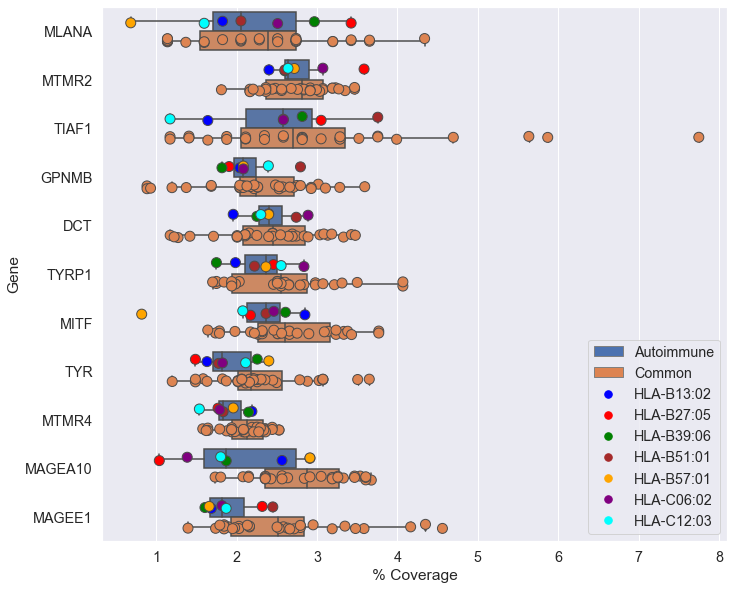

In [10]:
de_atgns_by_diff = pct_cvr_diff[pct_cvr_diff.index.isin(de_atgns)].sort_values(ascending=False).index

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=pct_cvr_long[pct_cvr_long.Gene.isin(de_atgns_by_diff)], y='Gene', x='% Coverage', hue='Allele Set',
            order=de_atgns_by_diff, ax=ax)
sns.stripplot(data=pct_cvr_long[pct_cvr_long.Gene.isin(de_atgns_by_diff)], y='Gene', x='% Coverage', hue='Allele Set',
              order=de_atgns_by_diff, dodge=True, linewidth=1, size=10, ax=ax)

al_order = ['HLA-B13:02','HLA-B27:05','HLA-B39:06','HLA-B51:01','HLA-B57:01','HLA-C06:02','HLA-C12:03']
for ai_pts_row in ax.collections[0:-2:2]:
    ai_pts_row.set_fc([allele_colors[al] for al in al_order])

new_handles = [
    mpl.patches.Patch(ec='grey', fc='C0', label='Autoimmune'),
    mpl.patches.Patch(ec='grey', fc='C1', label='Common')
]
new_handles.extend([
    mpl.lines.Line2D([], [], marker='.', ms=15, ls='', c=c, label=al) for al, c in sorted(allele_colors.items())
])
lgd = plt.legend(handles=new_handles, loc='best')

fig.tight_layout(pad=0);

/tmp/ipykernel_4012992/2463543887.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pct_cvr_long = pct_cvr_long.append(pop_pct_cvr.reset_index().melt(id_vars='hgnc', var_name='allele', value_name='pct_coverage').assign(al_set='Common'), ignore_index=True)


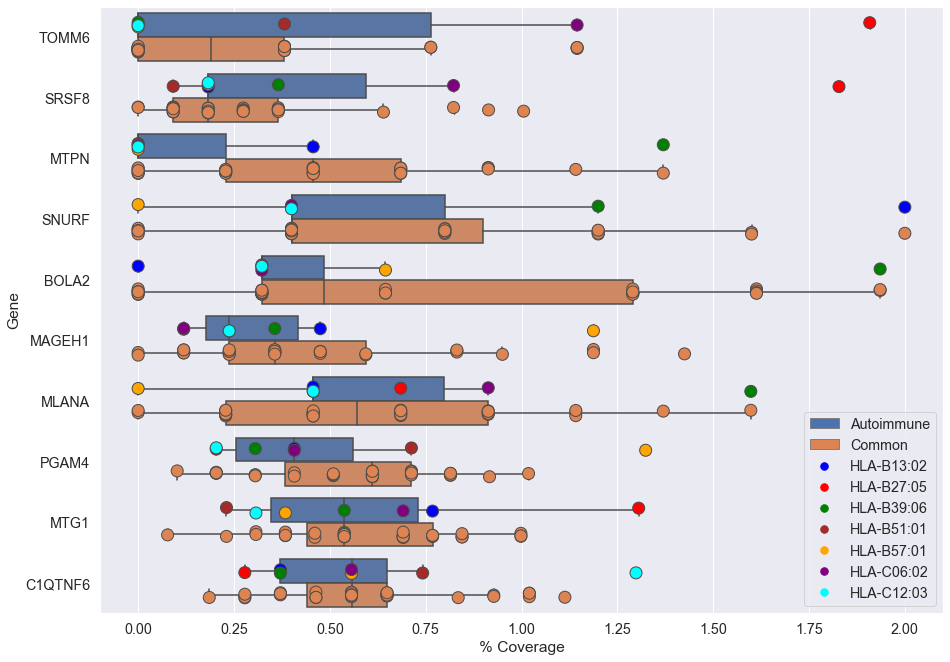

In [11]:
thresh = 0.5
ai_bp = bp_idxd.loc[:, bp_idxd.columns.isin(ai_alleles)]
pop_bp = bp_idxd.loc[:, bp_idxd.columns.isin(pop_alleles)]

# Percent coverage = no. of uniq peptides below threshold/(gene length * no. of tested alleles) * 100%
ai_pct_cvr = (ai_bp <= thresh).groupby('hgnc').sum().div(bp_idxd.groupby('hgnc').size(), 0) * 100
ai_pct_cvr.sort_index(inplace=True)

pop_pct_cvr = (pop_bp <= thresh).groupby('hgnc').sum().div(bp_idxd.groupby('hgnc').size(), 0) * 100
pop_pct_cvr.sort_index(inplace=True)

pct_cvr_long = ai_pct_cvr.reset_index().melt(id_vars='hgnc', var_name='allele', value_name='pct_coverage').assign(al_set='Autoimmune')
pct_cvr_long = pct_cvr_long.append(pop_pct_cvr.reset_index().melt(id_vars='hgnc', var_name='allele', value_name='pct_coverage').assign(al_set='Common'), ignore_index=True)
pct_cvr_long = pct_cvr_long.rename(columns={'hgnc': 'Gene', 'pct_coverage': '% Coverage', 'al_set': 'Allele Set'})

pct_cvr_diff = (ai_pct_cvr.max(1) - pop_pct_cvr.mean(1))/pop_pct_cvr.mean(1)*100
pct_cvr_diff = pct_cvr_diff.reindex(pct_cvr_diff.abs().sort_values(ascending=False).index)
top_n_pct_diff = pct_cvr_diff.nlargest(10).index

fig, ax = plt.subplots(figsize=(13, 9))

sns.boxplot(data=pct_cvr_long[pct_cvr_long.Gene.isin(top_n_pct_diff)], y='Gene', x='% Coverage', hue='Allele Set',
            order=top_n_pct_diff, ax=ax)
sns.stripplot(data=pct_cvr_long[pct_cvr_long.Gene.isin(top_n_pct_diff)], y='Gene', x='% Coverage', hue='Allele Set',
              order=top_n_pct_diff, dodge=True, linewidth=1, size=12, ax=ax)

al_order = ['HLA-B13:02','HLA-B27:05','HLA-B39:06','HLA-B51:01','HLA-B57:01','HLA-C06:02','HLA-C12:03']
for ai_pts_row in ax.collections[0:-2:2]:
    ai_pts_row.set_fc([allele_colors[al] for al in al_order])

new_handles = [
    mpl.patches.Patch(ec='grey', fc='C0', label='Autoimmune'),
    mpl.patches.Patch(ec='grey', fc='C1', label='Common')
]
new_handles.extend([
    mpl.lines.Line2D([], [], marker='.', ms=15, ls='', c=c, label=al) for al, c in sorted(allele_colors.items())
])
lgd = plt.legend(handles=new_handles, loc='best')

fig.tight_layout(pad=0);

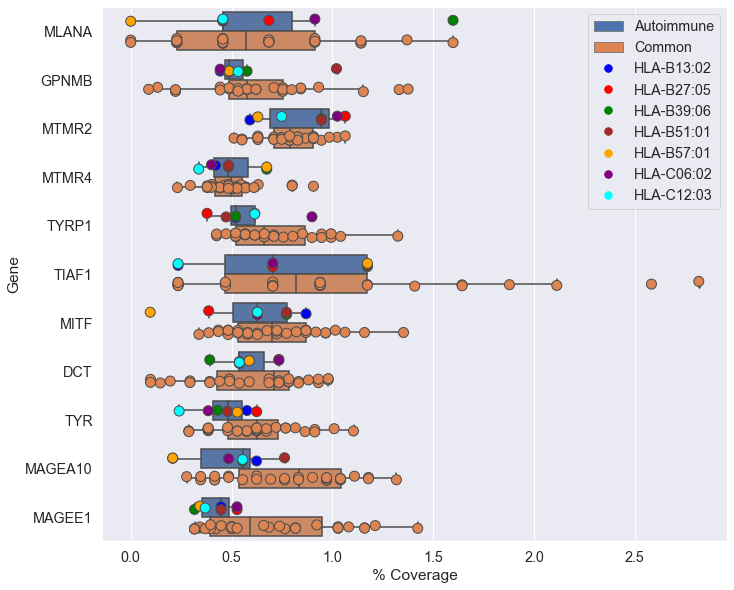

: 

In [12]:
de_atgns_by_diff = pct_cvr_diff[pct_cvr_diff.index.isin(de_atgns)].sort_values(ascending=False).index

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=pct_cvr_long[pct_cvr_long.Gene.isin(de_atgns_by_diff)], y='Gene', x='% Coverage', hue='Allele Set',
            order=de_atgns_by_diff, ax=ax)
sns.stripplot(data=pct_cvr_long[pct_cvr_long.Gene.isin(de_atgns_by_diff)], y='Gene', x='% Coverage', hue='Allele Set',
              order=de_atgns_by_diff, dodge=True, linewidth=1, size=10, ax=ax)

al_order = ['HLA-B13:02','HLA-B27:05','HLA-B39:06','HLA-B51:01','HLA-B57:01','HLA-C06:02','HLA-C12:03']
for ai_pts_row in ax.collections[0:-2:2]:
    ai_pts_row.set_fc([allele_colors[al] for al in al_order])

new_handles = [
    mpl.patches.Patch(ec='grey', fc='C0', label='Autoimmune'),
    mpl.patches.Patch(ec='grey', fc='C1', label='Common')
]
new_handles.extend([
    mpl.lines.Line2D([], [], marker='.', ms=15, ls='', c=c, label=al) for al, c in sorted(allele_colors.items())
])
lgd = plt.legend(handles=new_handles, loc='best')

fig.tight_layout(pad=0);